In today's energy-conscious world, understanding and optimizing household electricity usage is more important than ever. This project leverages four years of detailed power consumption data from homes to build machine learning models that predict future energy needs.

## The Data

Available in `df_train.csv` and `df_test.csv`:

| Column             | Type   | Description                                                                 |
|--------------------|--------|----------------------------------------------------------------------------|
| date               | chr    | Date of the measurement                                                    |
| power_consumption  | dbl    | Daily power consumption (in kilowatts)                                     |
| year               | int    | Year of the measurement                                                    |
| semester           | int    | Semester of the measurement (1 for Jan-Jun, 2 for Jul-Dec)                 |
| quarter            | int    | Quarter of the measurement (1 for Q1, 2 for Q2, 3 for Q3, 4 for Q4)        |
| day_in_week        | chr    | Day of the week of the measurement (e.g., Monday, Tuesday)                 |
| week_in_year       | int    | Week number in the year of the measurement                                 |
| day_in_year        | int    | Day number in the year of the measurement                                  |
| month              | int    | Month of the year of the measurement                                       |

This dataset was donated to the UCI Machine Learning Repository.

In [1]:
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn

## Set style

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## Load and inspect the data

In [3]:
import pandas as pd

# Load the training and test datasets
df_train = pd.read_csv('df_train.csv')  # Load training dataset
df_test = pd.read_csv('df_test.csv')    # Load test dataset

### Explore the structure of df_train

In [4]:
# Displays structure
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               1202 non-null   object 
 1   power_consumption  1202 non-null   float64
 2   year               1202 non-null   int64  
 3   semester           1202 non-null   int64  
 4   quarter            1202 non-null   int64  
 5   day_in_week        1202 non-null   object 
 6   week_in_year       1202 non-null   int64  
 7   day_in_year        1202 non-null   int64  
 8   month              1202 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 84.6+ KB


In [5]:
# Displays first rows
df_train.head()

date  power_consumption  year  semester  quarter day_in_week  \
0  12/16/2006           1209.176  2006         2        4         Sat   
1  12/17/2006           3390.460  2006         2        4         Sun   
2  12/18/2006           2203.826  2006         2        4         Mon   
3  12/19/2006           1666.194  2006         2        4         Tue   
4  12/20/2006           2225.748  2006         2        4         Wed   

   week_in_year  day_in_year  month  
0            50          350     12  
1            51          351     12  
2            51          352     12  
3            51          353     12  
4            51          354     12

## Data Preprocessing

In [6]:
from datetime import datetime

# Convert 'date' column to Date type and 'day_in_week' to factor (categorical variable)
def preprocess_data_simple(df_train, df_test):
    # Convert dates
    df_train['date'] = pd.to_datetime(df_train['date'], format='%m/%d/%Y')
    df_test['date'] = pd.to_datetime(df_test['date'], format='%m/%d/%Y')

    # One-Hot Encoding with get_dummies
    df_train = pd.get_dummies(df_train, columns=['day_in_week'], drop_first=True)
    df_test = pd.get_dummies(df_test, columns=['day_in_week'], drop_first=True)

    return df_train, df_test

## Separation of Features (X) and Target Variable (y)

In [7]:
# The target variable is 'power_consumption'
# 'power_consumption' and 'date' are excluded from the features
train_x = df_train.drop(columns=["power_consumption", "date"])
train_y = df_train["power_consumption"]
test_x = df_test.drop(columns=["power_consumption", "date"])
test_y = df_test["power_consumption"]

## Model Training and Evaluation using RMSE

In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [9]:
# Identify categorical columns
categorical_cols = ['day_in_week']  # add any other categorical columns here
numerical_cols = [col for col in train_x.columns if col not in categorical_cols]

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Model 1: Linear Regression with proper encoding
lm_pipeline = make_pipeline(
    preprocessor,
    LinearRegression()
)
lm_pipeline.fit(train_x, train_y)
lm_pred = lm_pipeline.predict(test_x)
lm_rmse = np.sqrt(mean_squared_error(test_y, lm_pred))
print(f"Linear Regression RMSE: {lm_rmse:.4f}")

# Model 2: Random Forest with proper encoding
rf_pipeline = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)
)
rf_pipeline.fit(train_x, train_y)
rf_pred = rf_pipeline.predict(test_x)
rf_rmse = np.sqrt(mean_squared_error(test_y, rf_pred))
print(f"Random Forest RMSE: {rf_rmse:.4f}")

# Model 3: XGBoost (handles categoricals internally when specified)
# First convert categorical columns to category dtype
for col in categorical_cols:
    train_x[col] = train_x[col].astype('category')
    test_x[col] = test_x[col].astype('category')

xgb_model = XGBRegressor(
    n_estimators=500,
    objective="reg:squarederror",
    learning_rate=0.1,
    max_depth=1,
    random_state=42,
    verbosity=0,
    enable_categorical=True  # Important for categorical support
)
xgb_model.fit(train_x, train_y)
xgb_pred = xgb_model.predict(test_x)
xgb_rmse = np.sqrt(mean_squared_error(test_y, xgb_pred))
print(f"XGBoost RMSE: {xgb_rmse:.4f}")

Linear Regression RMSE: 504.2986
Random Forest RMSE: 431.9402
XGBoost RMSE: 405.2913


## Results Comparison

In [10]:
# Display RMSE scores for all models
rmse_results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [lm_rmse, rf_rmse, xgb_rmse]
})

print(rmse_results)

# Identify and display the lowest RMSE (best model)
selected_rmse = min(lm_rmse, rf_rmse, xgb_rmse)
best_model = rmse_results.loc[rmse_results['RMSE'].idxmin(), 'Model']
print(f"Best performing model: {best_model}, {selected_rmse:.4f} kW")

               Model        RMSE
0  Linear Regression  504.298592
1      Random Forest  431.940241
2            XGBoost  405.291339
Best performing model: XGBoost, 405.2913 kW


## Results Visualization and Analysis

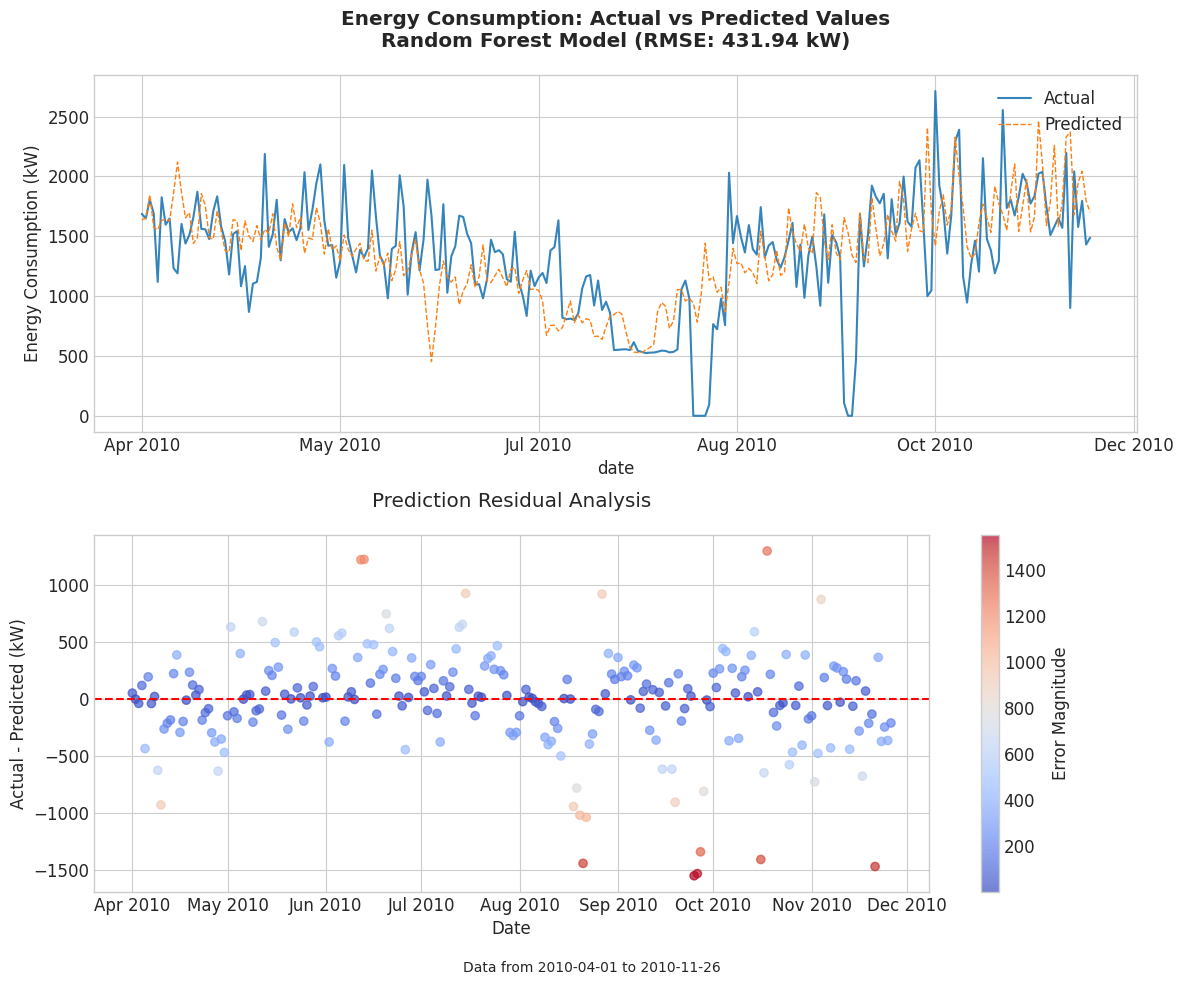


Model Performance Metrics:
● RMSE: 431.94 kW
● Correlation: 0.531
● Trend Similarity: Moderate


In [11]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
from matplotlib.dates import DateFormatter

# Ensure date conversion
df_test['date'] = pd.to_datetime(df_test['date'])  # Add format='%m/%d/%Y' if needed

# Add predictions to test data
df_test = df_test.assign(
    Predicted=rf_pred,
    Residual=lambda x: x['power_consumption'] - x['Predicted'],
    Prediction_Error=lambda x: np.abs(x['Residual'])
)

# Set up visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12
colors = {"Actual": "#1f77b4", "Predicted": "#ff7f0e"}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))


# ===== ACTUAL VS PREDICTED PLOT =====
sns.lineplot(data=df_test, x='date', y='power_consumption',
             color=colors["Actual"], label='Actual',
             linewidth=1.5, alpha=0.9, ax=ax1)
sns.lineplot(data=df_test, x='date', y='Predicted',
             color=colors["Predicted"], label='Predicted',
             linestyle='--', linewidth=1, ax=ax1)

# Formatting
ax1.set_title(f"Energy Consumption: Actual vs Predicted Values\nRandom Forest Model (RMSE: {rf_rmse:.2f} kW)",
              fontweight='bold', pad=20)
ax1.set_ylabel("Energy Consumption (kW)")
ax1.legend(loc='upper right')

# Date formatting
date_format = DateFormatter("%b %Y")
ax1.xaxis.set_major_formatter(date_format)
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))


# ===== RESIDUAL PLOT =====
scatter = ax2.scatter(df_test['date'], df_test['Residual'],
                      c=df_test['Prediction_Error'],
                      cmap='coolwarm', alpha=0.7)
ax2.axhline(0, color='red', linestyle='--')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Error Magnitude')

# Formatting
ax2.set_title("Prediction Residual Analysis", pad=20)
ax2.set_xlabel("Date")
ax2.set_ylabel("Actual - Predicted (kW)")
ax2.xaxis.set_major_formatter(date_format)

# Add caption
start_date = df_test['date'].min().strftime('%Y-%m-%d')
end_date = df_test['date'].max().strftime('%Y-%m-%d')
fig.text(0.5, 0.02, f"Data from {start_date} to {end_date}",
         ha="center", fontsize=10)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Make room for caption
plt.show()

# Quantitative assessment
correlation = df_test['power_consumption'].corr(df_test['Predicted'])
trend_similarity = ("Strong" if correlation > 0.7
                   else "Moderate" if correlation > 0.4
                   else "Weak")

print("\nModel Performance Metrics:")
print(f"● RMSE: {rf_rmse:.2f} kW")
print(f"● Correlation: {correlation:.3f}")
print(f"● Trend Similarity: {trend_similarity}")